## Keras & Deep Learning
- book : [Deep Learning with Python by Francois Chollet](https://www.amazon.com/Deep-Learning-Python-Francois-Chollet/dp/1617294438)
- source code : [github](https://github.com/fchollet/deep-learning-with-python-notebooks)
- Python_SPLIT #8 2019.3.28. Yoon Kyung Lee
- [git repository and notebooks](https://github.com/yoonlee78/cogpsi)

## Contents

1. working with text data
2. Understanding recurrent neural network
3. advanced use of recurrent neural network
4. Sequence processing with covnets


example of text analysis application: sentiment analysis : 
https://web.stanford.edu/class/cs124/lec/sentimentvideoslides2019.pdf

In [1]:
import keras

Using TensorFlow backend.


### 6.1 Working with text data 

Text is one of the most widesrpead forms of **sequence** data In can be understood as 

- sequence of characters
- sequence of words

The deep-learning sequence processing models introduced in the following sections can use text to produce a basic form of **natural-language understanding(NLU)**. 

<img src = "https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2017/01/11182015/image-5.png">

<div class="alert alert-block alert-success">
<font color = black> 
    
### Vetorizing text

deep-learning models don't take as input **raw text**. ONLY **numeric tensors**.

text vectorization : process of transforming text into numeric tensors

- segment text into words, and transform each word into a vector
- segment text into characters, and transform each character into a vector.
- extract n-grams of words or characters, and transform each n-gram into a vector. **N-grams** are overlapping groups of multiple consequtive words or characters

tokens: different units into which you can break down text (words, characters, or n-grams) 

tokenization: all text-vectorization processes consist of applying some tokenization scheme and then associating numeric vectors with the generated tokens. 

<div class="alert alert-block alert-info">
<font color = black>
    
<strong> Understanding n-grams and bag-of-words </strong>

<br>
Word n-grams are groups of _N_(or fewer) consecutive words that you can extract from a sentence. The same concept may also be applied to characters instead of words 

<br>

The term _bag_ here refers to the fact that you are dealing with a _set of tokens_ rather than a list or sequence: the tokens have no specific order. This family of tokenization methods is called _bag-of-words_. 

<br>
extracting n-grams is a form of _feature engineering_ 
<br>
<br>
1. Example 2-grams <br>

{"The", "The cat", "cat", "cat sat", "sat",
  "sat on", "on", "on the", "the", "the mat", "mat"}
<br>
<br>
2. Example 3-grams <br>

{"The", "The cat", "cat", "cat sat", "The cat sat",
  "sat", "sat on", "on", "cat sat on", "on the", "the",
  "sat on the", "the mat", "mat", "on the mat"}
<br>
<br>
**notice there are "unordered sets". 

</font>
</div>

multiple ways to associate vector with a token 

#### 1. one-hot encoding

#### 2. token embedding

This section explains these techniques and shows how to use them **to go from raw text to a NumPy tensor** that you can send to a Keras network. 

<img src="./imgs/text_to_tokens_to_vectors.png" alt="text to tokens to vectors" title="text vectorization" />

### 6.1.1. One-hot encoding of words and characters

#### One-hot encoding : the most common, most basic way to turn a token into a vector

vectors obtained through one-hot encoding are _binary_,_sparse_ (mostly made of zeros), and _very high-dimensional(same as the # of words in the vocab)_. 

<img src = "https://cdn-images-1.medium.com/max/1600/0*T5jaa2othYfXZX9W."/>

1. word-level one-hot encoding

In [2]:
import numpy as np

# This is our initial data; one entry per "sample"
# (in this toy example, a "sample" is just a sentence, but
# it could be an entire document).
samples = ['The cat sat on the mat.', 'The dog ate my homework.']

# First, build an index of all tokens in the data.
token_index = {}
for sample in samples:
    # We simply tokenize the samples via the `split` method.
    # in real life, we would also strip punctuation and special characters
    # from the samples.
    for word in sample.split():
        if word not in token_index:
            # Assign a unique index to each unique word
            token_index[word] = len(token_index) + 1
            # Note that we don't attribute index 0 to anything.

# Next, we vectorize our samples.
# We will only consider the first `max_length` words in each sample.
max_length = 10

# This is where we store our results:
results = np.zeros((len(samples), max_length, max(token_index.values()) + 1))
for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:max_length]:
        index = token_index.get(word)
        results[i, j, index] = 1.

2. character-level one-hot encoding

In [3]:
import string

samples = ['The cat sat on the mat.', 'The dog ate my homework.']
characters = string.printable  # All printable ASCII characters.
token_index = dict(zip(characters, range(1, len(characters) + 1)))

max_length = 50
results = np.zeros((len(samples), max_length, max(token_index.values()) + 1))
for i, sample in enumerate(samples):
    for j, character in enumerate(sample[:max_length]):
        index = token_index.get(character)
        results[i, j, index] = 1.

3. keras for word-level one-hot encoding

In [4]:
from keras.preprocessing.text import Tokenizer

samples = ['The cat sat on the mat.', 'The dog ate my homework.']

# We create a tokenizer, configured to only take
# into account the top-1000 most common words
tokenizer = Tokenizer(num_words=1000)
# This builds the word index
tokenizer.fit_on_texts(samples)

# This turns strings into lists of integer indices.
sequences = tokenizer.texts_to_sequences(samples)

# You could also directly get the one-hot binary representations.
# Note that other vectorization modes than one-hot encoding are supported!
one_hot_results = tokenizer.texts_to_matrix(samples, mode='binary')

# This is how you can recover the word index that was computed
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 9 unique tokens.


### 6.1.2 Using word embeddings

Word embeddings: another popular and powerful way to associate a vector with a word by using dense _word vectors_

Unlike one-hot encoding, word embeddings are _low-dimentional_ floating-point vectors (dense vectors as opposed to sparse vectors). 

<img src = "./imgs/one_hot_and_word_embedding.png"/>

### * 2 ways to obtain word embeddings

1. learn word embedding jointly with the main task you care about (such as document classification or sentiment prediction). In this setup, you start with random word vectors and then learn word vectors in the same way you learn the weights of a neural network. 

2. Load into your model word embeddings that were precomputed using a different machine-learning task that the one you're trying to solve. These are called **_pretrained word embeddings_**

Let's look at both

### some concepts

<div class="alert alert-block alert-info">
<font color = black> 

 <br> vector space </b>

<br>
 word embeddings are meant to **map** human language into a geometric space 
 <img src = "./imgs/word_mapping.png"/>
 <br>

 <br>
 </font>
</div>

<div class="alert alert-block alert-info">
<font color = black> 

<b> distance and directions : </b>
<br>
<br>
distance :
<br>
wolf : dog <br>
tiger : cat <br>
tiger : dog <br>
<br>
directions:
<br>
dog to wolf : pet to wild animal

wolf to tiger : canine to feline 
<br>
</font>
</div>


In real-world word-embedding spaces, common examples of meaningful geometric transformations are **“gender”**
vectors and **“plural”** vectors. 

For instance, by adding a **“female”** vector to the vector **“king,” **we obtain the vector **“queen.”** By adding a **“plural”** vector, we obtain **“kings.”** 

Word-embedding spaces typically feature thousands of such interpretable and potentially useful vectors.

1. Learning word embeddings with the embedded layer

**The simplest way to associate a dense vector with a word = to choose the vector at random**

But more pragmatically, what makes a good word-embedding space depends heavily on your task: the perfect word-embedding space for an **English-language movie-review sentiment-analysis model** may look different from the perfect embedding space for an **English- language legal-document-classification model**, because the importance of certain semantic relationships varies from task to task. <br>

example:



It’s thus reasonable to **learn a new embedding space with every new task**. Fortunately, **backpropagation** makes this easy, and Keras makes it even easier. **It’s about learning the weights of a layer: the Embedding layer.**

In [5]:
from keras.layers import Embedding

# The Embedding layer takes at least two arguments:
# the number of possible tokens, here 1000 (1 + maximum word index),
# and the dimensionality of the embeddings, here 64.
embedding_layer = Embedding(1000, 64)

#### embedding layer 

"a dictionary lookup": a dictionary that maps integer indices (which stand for specific words) to dense vectors. 

It taks integers as input, it looks up these integers in an internal dictionary and returns the associated vectors. 





<img src = "./imgs/word_embedding.png" width = 500 >

The ```embedding``` layer takes as input a **2D tensor** of integers, of shape ```(samples, sequence_length)```, where each entry is a sequence of integers. 

It can embed seqeuences of variable lengths: for instance, you could feed into the ```Embedding```layer in the previous example batches with shapes ```(32,10)``` (batch of 32 sequences of length 10) or (64, 15) (batch of 64 sequences of length 15). 

All sequences in a batch must have the same length, though (because you need to pack them into a single tensor), so sequences that are shorter than others should be padded with _zeros_, and sequences that are longer should be **_truncated_.** 

This layer returns a 3D floating-point tensor of shape (samples, sequence_length, embedding_dimensionality). Such a  3D tensor can be processed by an RNN layer of a 1D convolution layer (to be introduced in the following sections). 

When you instantiate an embedding layer, its **weights** (its internatl dictionary of token vectors) are intially **random** just as with any other layer. 

During training, these word vetcors are gradually adjusted via **backgprobagation**, structuring the space into something the **downstream model can exploit**. Once fully trained, the embedding space will show a lot of structure- a kind of structure specialized for the specific problem for which you are training your model-. 

### Word Embedding with IMDB data

Let's apply this idea to the IMDB movie review sentiment prediction task that you are already familiar with. Let's quickly prepare the data. We will restrict the movie reviews to the top 10,000 most common words (like we did the first time we worked with this dataset), and cut the reviews after only 20 words. Our network will simply learn **8-dimensional embeddings** for each of the **10,000 words**, turn the **input integer sequences (2D integer tensor) into embedded sequences (3D float tensor)**, **flatten the tensor to 2D**, and train a **single Dense layer on top for classification.**


In [6]:
from keras.datasets import imdb
from keras import preprocessing

# Number of words to consider as features
max_features = 10000
# Cut texts after this number of words 
# (among top max_features most common words)
maxlen = 20

# Load the data as lists of integers.
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# This turns our lists of integers
# into a 2D integer tensor of shape `(samples, maxlen)`
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

In [7]:
from keras.models import Sequential
from keras.layers import Flatten, Dense

model = Sequential()
# We specify the maximum input length to our Embedding layer
# so we can later flatten the embedded inputs
model.add(Embedding(10000, 8, input_length=maxlen))
# After the Embedding layer, 
# our activations have shape `(samples, maxlen, 8)`.

# We flatten the 3D tensor of embeddings 
# into a 2D tensor of shape `(samples, maxlen * 8)`
model.add(Flatten())

# We add the classifier on top
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 20, 8)             80000     
_________________________________________________________________
flatten_1 (Flatten)          (None, 160)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 161       
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________
Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 5s 233us/step - loss: 0.6759 - acc: 0.6051 - val_loss: 0.6398 - val_acc: 0.6812
Epoch 2/10
20000/20000 [==============================] - 5s 231us/step - loss: 0.5657 - acc: 0.7426 - val_loss: 0.5467 - val_acc: 0.7204
Epoch 3/10
20000/20000 [==============================] - 4s 184us/step - los

We get to a validation accuracy of **~76%**, which is pretty good considering that we only look at the first 20 words in every review. 

But note that merely flattening the embedded sequences and training a single Dense layer on top leads to a model that treats each word in the input sequence separately, **without considering inter-word relationships and structure sentence** (e.g. it would likely treat both "this movie is shit" and "this movie is the shit" as being negative "reviews"). 

It would be much better to add recurrent layers or 1D convolutional layers on top of the embedded sequences to learn features that take into account each sequence as a whole. That's what we will focus on in the next few sections.

### Using pre-trained word embeddings

Sometimes, you have so little training data available that could never use your data alone to learn an appropriate task-specific embedding of your vocabulary. What to do then?

 loading embedding vectors from a pre-computed embedding space known to be highly structured and to exhibit useful properties -- that captures generic aspects of language structure. 
 
The idea of a dense, low-dimensional embedding space for words, computed in an unsupervised way, was initially explored by **Bengio et al.** in the early 2000s, but it only started really taking off in research and industry applications after the release of one of the most famous and successful word embedding scheme: **the Word2Vec algorithm**, developed by Mikolov at Google in 2013. Word2Vec dimensions capture specific semantic properties, e.g. gender.

There are various pre-computed databases of word embeddings that can download and start using in a Keras Embedding layer. Word2Vec is one of them. Another popular one is called **"GloVe"**, developed by Stanford researchers in 2014. It stands for "Global Vectors for Word Representation", and it is an embedding technique based on factorizing a matrix of word co-occurrence statistics. Its developers have made available pre-computed embeddings for millions of English tokens, obtained from Wikipedia data or from Common Crawl data.

<br>
<br>
Yoshua Bengio, Tomas Mikolov, Manning et al.
<br>


<img src = "https://mila.quebec/wp-content/uploads/2018/11/Yoshua-Bengio-2018-e1543947393111-500x550.jpg" width = "200" height = "80" align = "left"/>      
<img src = "https://research.fb.com/wp-content/uploads/2016/11/people_tomas-milkolov.jpg" width = 200 align = "left"/>
<img src = "https://nlp.stanford.edu/manning/images/Christopher_Manning_027_132x132.jpg" width = 200 align = "left"/>



### 6.1.3. Putting it all together: from raw text to word embeddings

We will be using a model similar to the one we just went over --

1) **embedding sentences in sequences of vectors,** <br>
2) flattening them and training a  Dense layer on top. But we will do it using **pre-trained word embeddings,** <br>
3) and instead of using the pre-tokenized IMDB data packaged in Keras, we will start **from scratch**, by downloading the **original text data.** <br>

### Download the IMDB data as raw text

First, head to http://ai.stanford.edu/~amaas/data/sentiment/ and download the raw IMDB dataset (if the URL isn't working anymore, just Google "IMDB dataset"). Uncompress it.

Now let's collect the individual training reviews into a list of strings, one string per review, and let's also collect the review labels (positive / negative) into a labels list:

**방법**

[Large Movie Review Dataset v1.0 ](http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz) <- 다운로드

In [11]:
!ls

Chp06_DeepLearning_for_Text_and_Sequences.ipynb
François Chollet - Deep Learning with Python-Manning (2018).pdf
aclImdb
imgs


In [16]:
import os

imdb_dir = './aclImdb'#본 데이터를 다운로드 해놓은 경로를 입력 
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

### Tokenize the data

Let's **vectorize** the texts we collected, and prepare a **training** and **validation split**. We will merely be using the concepts we introduced earlier in this section.

Because pre-trained word embeddings are meant to be particularly useful on problems where little training data is available (otherwise, task-specific embeddings are likely to outperform them), we will add the following twist: **we restrict the training data to its first 200 samples.** So we will be learning to classify movie reviews after looking at just 200 examples...

In [17]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100  # We will cut reviews after 100 words
training_samples = 200  # We will be training on 200 samples
validation_samples = 10000  # We will be validating on 10000 samples
max_words = 10000  # We will only consider the top 10,000 words in the dataset

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# Split the data into a training set and a validation set
# But first, shuffle the data, since we started from data
# where sample are ordered (all negative first, then all positive).
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Found 88582 unique tokens.
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


### Download the GloVe word embeddings

to download GloVe algorithm, go to https://nlp.stanford.edu/projects/glove/

download the pre-computed embeddings from 2014 English Wikipedia. It's a 822MB zip file named glove.6B.zip, containing 100-dimensional embedding vectors for 400,000 words (or non-word tokens). Un-zip it.

<div class="alert alert-block alert-info">
<font color = black> 
    
<b>방법</b> <br>
1) Download pre-trained word vectors 섹션 아래 있는 <br>
2) Wikipedia 2014 + Gigaword 5 (6B tokens, 400K vocab, uncased, 50d, 100d, 200d, & 300d vectors, 822 MB download): [glove.6B.zip](http://nlp.stanford.edu/data/glove.6B.zip) <- 다운로드 <br>
3) **압축해제 후 같은 경로 안에 폴더를 넣어둘 것.** <br>
    
</font>
</div>

### Pre-process the embeddings

Let's parse the un-zipped file (**.txt**) to build an index mapping words (as strings) to their vector representation (as number vectors). 

In [18]:
glove_dir = './glove.6B' #본인의 디렉토리로 수정

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


Now let's build an **embedding matrix** that we will be able to load into an Embedding layer. It must be a matrix of shape (max_words, embedding_dim), where each entry i contains the embedding_dim-dimensional vector for the word of index i in our reference word index (built during tokenization). 

<b>Note that the index 0 is not supposed to stand for any word or token -- it's a placeholder.</b>

In [19]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

### Define a model 

same model architecture as before: 

In [20]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


### Load the GloVe embeddings in the model

The ```embedding``` layer has a single weight matrix: a 2D float matrix where each entry ```i``` is the word vector meant to be associated with index ```i```. 

Let's load the GloVe matrix we prepared into our Embedding layer: the first layer in our model. 

In [21]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False #trainable=false?

### Train and evaluate 

Let's compile our model and train it 


In [22]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 8s 41ms/step - loss: 1.9490 - acc: 0.5000 - val_loss: 0.6942 - val_acc: 0.5137
Epoch 2/10
200/200 [==============================] - 7s 37ms/step - loss: 0.5860 - acc: 0.7000 - val_loss: 0.7962 - val_acc: 0.5118
Epoch 3/10
200/200 [==============================] - 8s 39ms/step - loss: 0.5133 - acc: 0.7600 - val_loss: 0.7094 - val_acc: 0.5530
Epoch 4/10
200/200 [==============================] - 8s 39ms/step - loss: 0.3898 - acc: 0.8450 - val_loss: 0.9263 - val_acc: 0.5250
Epoch 5/10
200/200 [==============================] - 8s 40ms/step - loss: 0.3968 - acc: 0.8000 - val_loss: 0.7036 - val_acc: 0.5703
Epoch 6/10
200/200 [==============================] - 8s 41ms/step - loss: 0.1351 - acc: 0.9800 - val_loss: 1.7349 - val_acc: 0.4937
Epoch 7/10
200/200 [==============================] - 8s 41ms/step - loss: 0.2523 - acc: 0.8700 - val_loss: 0.7309 - val_acc: 0.5699
Epoch 8/10
200/200 [=

Let's plot this performance ove time:

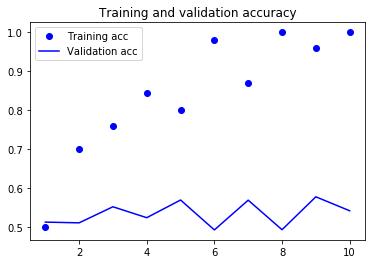

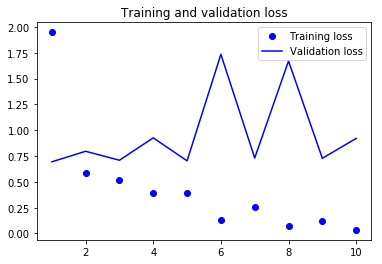

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

The model quickly starts **overfitting**, unsurprisingly given the small number of training samples. Validation accuracy has high variance for the same reason, but seems to reach high 50s.

Note that your mileage may vary: since we have so **few training samples**, performance is heavily dependent on **which exact 200 samples we picked**, and **we picked them at random.** If it worked really poorly for you, try picking a different random set of 200 samples, just for the sake of the exercise (in real life you don't get to pick your training data).

We can also try to train the same model without loading the pre-trained word embeddings and without freezing the embedding layer. In that case, we would be learning a task-specific embedding of our input tokens, which is generally more powerful than pre-trained word embeddings when lots of data is available. However, in our case, we have only 200 training samples. Let's try it:

In [25]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_3 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________
Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 10s 52ms/step - loss: 0.6941 - acc: 0.4950 - val_loss: 0.6955 - val_acc: 0.5178
Epoch 2/10
200/200 [==============================] - 9s 43ms/step - loss: 0.5001 

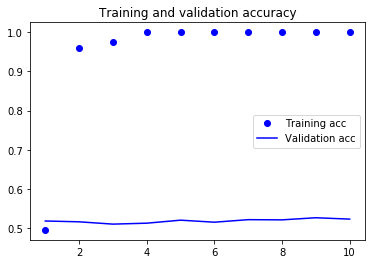

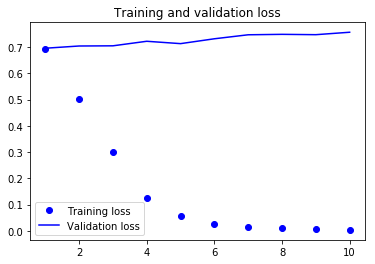

In [26]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Let's evaluate 

In [27]:
test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

Let's load and evaluate the first model: 

In [28]:
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

25000/25000 [==============================] - 20s 788us/step


[0.9360345366668701, 0.53548]

We get an appalling test accuracy of 54%. Working with just a handful of training samples is hard!